In [72]:
import time

import numpy as np
import cv2
from scipy import signal, ndimage
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torchvision
from torch import Tensor, nn
from torch.nn import functional as F
import kornia

5083 samples per second

supervised data:
cam_theta_objs [ 160.96823    55.353996 -120.08079 ]
cam_t_objs [[-0.03705511  0.15570499]
 [-0.18284036  0.09799209]
 [-0.03770886  0.0944648 ]]


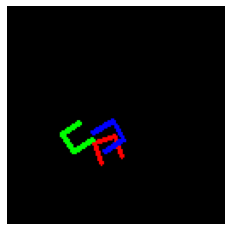


unsupervised data:
cam_a_theta_cam_b -85.55718
cam_a_t_cam_b [0.19059111 0.09243178]


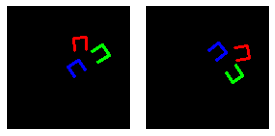

In [81]:
def nmz(a, axis=-1):
    return a / np.linalg.norm(a, axis=axis, keepdims=True)

def sample_disc(d):
    while True:
        p = np.random.randn(d)
        if np.linalg.norm(p) < 1:
            return p

def R_from_theta(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array(((c, -s), (s, c)))

def theta_from_R(R):
    return np.arctan2(R[1, 0], R[0, 0])

assert np.allclose(theta_from_R(R_from_theta(1)), 1)

def random_pose():
    R = R_from_theta(np.random.uniform(0, np.pi * 2))
    t = sample_disc(2) * 0.25
    return R, t

def mat(R, t):
    m = np.empty((3, 3))
    m[:2, :2] = R
    m[:2, 2] = t
    m[2] = 0, 0, 1
    return m

def inv(R, t):
    return R.T, -t @ R

def mult(Ra, ta, Rb, tb):
    return Ra @ Rb, ta + tb @ Ra.T


def gkern_pos(img_size, std=3, pos = (0,0)):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = signal.gaussian(img_size*2, std=std).reshape(img_size*2, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d[img_size-pos[1]:2*img_size-pos[1],img_size-pos[0]:2*img_size-pos[0]]


def gaussian(shape, pts):
    img = np.zeros(shape)
    pts = torch.clamp_(torch.round_((pts + 0.5) * shape[-1]).long(), 0, shape[-1]-1)
    sigma = 8
    # Draw a 2D gaussian for each heatmap in batch
    #[32, 3, 1, 128, 128]

    for entry in range(shape[0]):
        for object in range(shape[1]):
            pt = pts[entry,object]
            kern = gkern_pos(shape[-1],250,pt)

            img[entry,object, 0, ...] = kern


    return img

a_T_b, b_T_c = random_pose(), random_pose()
b_T_a, c_T_b = inv(*a_T_b), inv(*b_T_c)
a_T_c = mult(*a_T_b, *b_T_c)
c_T_a = mult(*c_T_b, *b_T_a)
assert np.allclose(mat(*a_T_c), mat(*inv(*c_T_a)))

class Dataset(torch.utils.data.Dataset):
    def __init__(self, res=128, epoch_size=1000, supervised=False):
        super().__init__()
        self.res = res
        self.u_shape = np.array([[-1, -1], [-1, 1], [1, 1], [1, -1]]) * res * 0.05
        self.colors = (1., 0., 0.), (0, 1., 0.), (0., 0., 1.)
        self.epoch_size = epoch_size
        self.supervised = supervised
        self.static_pose = [random_pose() for _ in range(2)]

    def __len__(self):
        return self.epoch_size

    def draw(self, cam_T_objs):
        r = self.res
        assert len(cam_T_objs) == len(self.colors)
        img = np.zeros((r, r, 3), dtype=np.float32)
        for color, (R, t) in zip(self.colors, cam_T_objs):
            shape = self.u_shape @ R.T + ((t + 0.5) * r)  # camera intrins.
            shape = np.round(shape).astype(int)
            cv2.polylines(img, [shape], False, color, 2)
        return img

    def __getitem__(self, idx):
        r = self.res

        world_T_cams = self.static_pose #[random_pose() for _ in range(2)]
        cam_T_worlds = [inv(*world_T_cam) for world_T_cam in world_T_cams]
        world_T_objs = [random_pose() for _ in self.colors]
        cams_T_objs = []

        for cam_T_world in cam_T_worlds:
            cam_T_objs = []
            for color, world_T_obj in zip(self.colors, world_T_objs):
                cam_T_objs.append(mult(*cam_T_world, *world_T_obj))
            cams_T_objs.append(cam_T_objs)

        img_a, img_b = [self.draw(c).transpose(2, 0, 1) for c in cams_T_objs]
        if self.supervised:
            a_R_objs = np.array([T[0] for T in cams_T_objs[0]], dtype=np.float32)
            a_t_objs = np.array([T[1] for T in cams_T_objs[0]], dtype=np.float32)
            return img_a, a_R_objs, a_t_objs
        else:
            a_R_b, a_t_b = mult(*cam_T_worlds[0], *world_T_cams[1])
            return img_a, img_b, a_R_b.astype(np.float32), a_t_b.astype(np.float32)

dataset = Dataset()
start = time.time()
fps = 0
while time.time() - start < 1:
    dataset[0]
    fps += 1
print(fps, 'samples per second\n')

print('supervised data:')
img, cam_R_objs, cam_t_objs = Dataset(supervised=True)[0]
print('cam_theta_objs', np.rad2deg([theta_from_R(R) for R in cam_R_objs]))
print('cam_t_objs', cam_t_objs)
plt.imshow(img.transpose(1, 2, 0))
plt.axis('off')
plt.show()
print()

print('unsupervised data:')
data = Dataset(supervised=False)
*imgs, a_R_b, a_t_b = data[0]

print('cam_a_theta_cam_b', np.rad2deg(theta_from_R(a_R_b)))
print('cam_a_t_cam_b', a_t_b)

fig, axs = plt.subplots(1, 2, figsize=(4, 2))
for ax, img in zip(axs, imgs):
    ax.imshow(img.transpose(1, 2, 0))
    ax.axis('off')
plt.tight_layout()
plt.show()


Unsupervised training could both be with or without knowing the pose between the two cameras

In [74]:
test = 0
def build_conv_layer(fi, fo, bn=True, k=3, upscale=False, pool=False):
    #  standard conv layer
    return nn.Sequential(
        nn.UpsamplingBilinear2d(scale_factor=2) if upscale else nn.Identity(),
        nn.Conv2d(fi, fo, kernel_size=k, padding=k//2),
        nn.BatchNorm2d(fo) if bn else nn.Identity(),
        nn.MaxPool2d(2, 2) if pool else nn.Identity(),
    )

class Model(nn.Module):
    def __init__(self, res=128, left=(3, 16, 32, 64), right=(64, 64, 32), n_objs=3, smooth_cs=True):
        super().__init__()
        right = *right, n_objs * 3
        assert len(left) == len(right)
        self.res = res
        self.n_objs = n_objs
        self.smooth_cs = smooth_cs
        layers = [build_conv_layer(fi, fo, pool=True) for fi, fo in zip(left, left[1:])]
        layers += [build_conv_layer(fi, fo, upscale=True) for fi, fo in zip(right, right[1:-1])]
        layers.append(build_conv_layer(right[-2], right[-1], upscale=True, bn=False))
        self.layers = nn.Sequential(*layers)

        coords = np.linspace(-.5, .5, res, dtype=np.float32)
        coords = np.stack(np.meshgrid(coords, coords))  # (x, y) coordinates!
        self.coords = nn.Parameter(torch.from_numpy(coords), False)

        self.eval()
        assert self.layers(torch.zeros(1, left[0], res, res)).shape == (1, n_objs * 3, res, res)
        self.train()

    def forward(self,x_a ):#, x_b):
        r = self.res
        assert x_a.shape[1:] == (3, r, r), x_a.shape
        #assert x_b.shape[1:] == (3, r, r), x_a.shape
        B = x_a.shape[0]
        # x.shape = [B, 2 , 3 , r , r]
        y_cam_a = self.layers(x_a)
        #y_cam_b = self.layers(x_b)

        heatmaps_a, cs_raw_a = y_cam_a[:, :self.n_objs], y_cam_a[:, self.n_objs:]
        #heatmaps_b, cs_raw_b = y_cam_b[:, :self.n_objs], y_cam_b[:, self.n_objs:]

        cs_raw_a = cs_raw_a.view(B, self.n_objs, 2, r, r)

        heatmaps_a = F.softmax(heatmaps_a.view(B, self.n_objs, -1), dim=-1).view(B, self.n_objs, 1, r, r)
        coords_a = heatmaps_a * self.coords.view(1, 1, 2, r, r)  # B, n_objs, 2, r, r
        coords_a = coords_a.sum(dim=(-1, -2))  # B, n_objs, 2

        '''
        cs_raw_b = cs_raw_b.view(B, self.n_objs, 2, r, r)

        heatmaps_b = F.softmax(heatmaps_b.view(B, self.n_objs, -1), dim=-1).view(B, self.n_objs, 1, r, r)
        coords_b = heatmaps_b * self.coords.view(1, 1, 2, r, r)  # B, n_objs, 2, r, r
        coords_b = coords_b.sum(dim=(-1, -2))  # B, n_objs, 2
        '''


        if self.smooth_cs:
            cs_a = torch.sum(heatmaps.detach() * cs_raw_a, dim=(-1, -2)) # B, n_objs, 2
        else:
            # there must be a better way than this crazy indexing?

            # idxs = coords as index in heatmaps (0 to 126)
            idxs = torch.clamp_(torch.round_((coords_a + 0.5) * r).long(), 0, r-1)  # B, n_objs, 2  (xy)
            cs_a = cs_raw_a[
                torch.arange(B).view((B, 1, 1)),                    # Take from all batches
                torch.arange(self.n_objs).view(1, self.n_objs, 1),  # for all objects
                torch.arange(2).view(1, 1, 2),                      #  sin and cos
                idxs[..., 1].view(B, self.n_objs, 1),               # at ys
                idxs[..., 0].view(B, self.n_objs, 1),               # and xs from idxs
            ]

        '''
        if self.smooth_cs:
            cs_b = torch.sum(heatmaps.detach() * cs_raw_b, dim=(-1, -2)) # B, n_objs, 2
        else:
            # there must be a better way than this crazy indexing?

            # idxs = coords as index in heatmaps (0 to 126)
            idxs = torch.clamp_(torch.round_((coords_b + 0.5) * r).long(), 0, r-1)  # B, n_objs, 2  (xy)
            cs_b = cs_raw_b[
                torch.arange(B).view((B, 1, 1)),                    # Take from all batches
                torch.arange(self.n_objs).view(1, self.n_objs, 1),  # for all objects
                torch.arange(2).view(1, 1, 2),                      #  sin and cos
                idxs[..., 1].view(B, self.n_objs, 1),               # at ys
                idxs[..., 0].view(B, self.n_objs, 1),               # and xs from idxs
            ]
        '''


        return coords_a, cs_a, heatmaps_a, cs_raw_a #, coords_b, cs_b, heatmaps_b, cs_raw_b
    '''
    def forward(self, x):
        r = self.res
        assert x.shape[1:] == (3, r, r), x.shape
        B = x.shape[0]
        #y = output from model, size :(Batch_size, N_objecs * 3, res, res)
        y = self.layers(x)

        # heatmaps = the first n_objs res*res heatmaps from each output in batch, cs_raw the rest
        heatmaps, cs_raw = y[:, :self.n_objs], y[:, self.n_objs:]

        cs_raw = cs_raw.view(B, self.n_objs, 2, r, r)

        heatmaps = F.softmax(heatmaps.view(B, self.n_objs, -1), dim=-1).view(B, self.n_objs, 1, r, r)
        coords = heatmaps * self.coords.view(1, 1, 2, r, r)  # B, n_objs, 2, r, r
        coords = coords.sum(dim=(-1, -2))  # B, n_objs, 2


        if self.smooth_cs:
            cs = torch.sum(heatmaps.detach() * cs_raw, dim=(-1, -2)) # B, n_objs, 2
        else:
            # there must be a better way than this crazy indexing?

            # idxs = coords as index in heatmaps (0 to 126)
            idxs = torch.clamp_(torch.round_((coords + 0.5) * r).long(), 0, r-1)  # B, n_objs, 2  (xy)
            cs = cs_raw[
                torch.arange(B).view((B, 1, 1)),                    # Take from all batches
                torch.arange(self.n_objs).view(1, self.n_objs, 1),  # for all objects
                torch.arange(2).view(1, 1, 2),                      #  sin and cos
                idxs[..., 1].view(B, self.n_objs, 1),               # at ys
                idxs[..., 0].view(B, self.n_objs, 1),               # and xs from idxs
            ]

            #cs = torch.gather(cs_raw,1, idxs.view(B,self.n_objs,2,1,1)).view(B,self.n_objs,2)
            #print( test)

    '''



### Model comments:
The architecture is a pretty standard encoder-decoder architecture. See eg. [Unet](https://arxiv.org/abs/1505.04597) (but without bilateral connections for simplicity).

x, y and theta are not regressed directly:

- x and y are regressed using an implicit heatmap (see [DSNT](https://arxiv.org/abs/1801.07372)).
- Representing the angle as a single scalar eg. [0, 2pi[ has a singularity where it wraps. Instead, cos(theta) and sin(theta) are regressed.

# Supervised training

  0%|          | 0/320 [00:00<?, ?it/s]

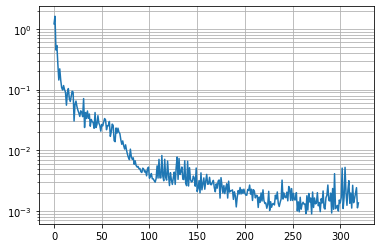

In [75]:
res = 128
n_epochs = 10
epoch_size = 1000
device = torch.device('cuda')

dataset = Dataset(res=res, epoch_size=epoch_size, supervised=True)
worker_init_fn = lambda *_: np.random.seed()
dataloader = torch.utils.data.DataLoader(dataset, 32, num_workers=4, worker_init_fn=worker_init_fn)
model = Model(res=res, smooth_cs=False).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

pbar = tqdm(total=n_epochs*len(dataloader))
losses = []
for epoch in range(n_epochs):
    for datapoint in dataloader:
        imgs, cam_R_objs, cam_t_objs = [d.to(device) for d in datapoint]

        coords, cs, heatmaps, cs_raw = model(imgs)

        cs_gt = cam_R_objs[..., (0, 1), (0, 0)]

        pos_loss = F.mse_loss(coords, cam_t_objs)
        orn_loss = F.mse_loss(cs, cs_gt)

        loss = pos_loss + orn_loss
        if model.smooth_cs:
            loss += 1e-3 * (cs_raw ** 2).mean()

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

        pbar.update()

plt.plot(losses)
plt.yscale('log')
plt.grid(which='both')

# Unsupervised training

  0%|          | 0/320 [00:00<?, ?it/s]

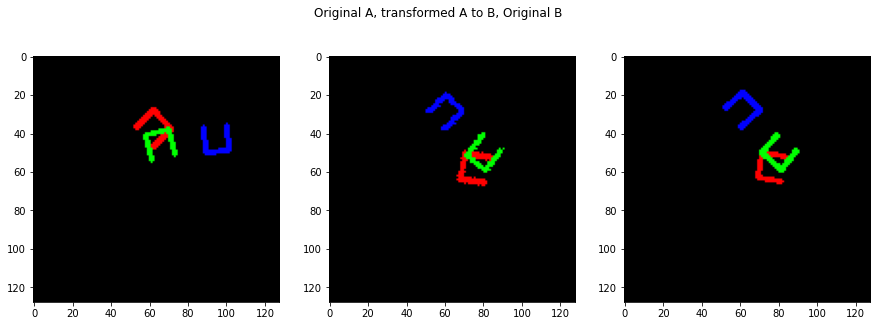

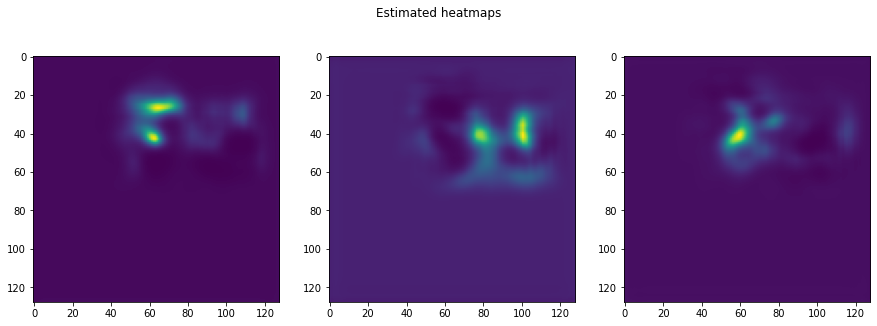

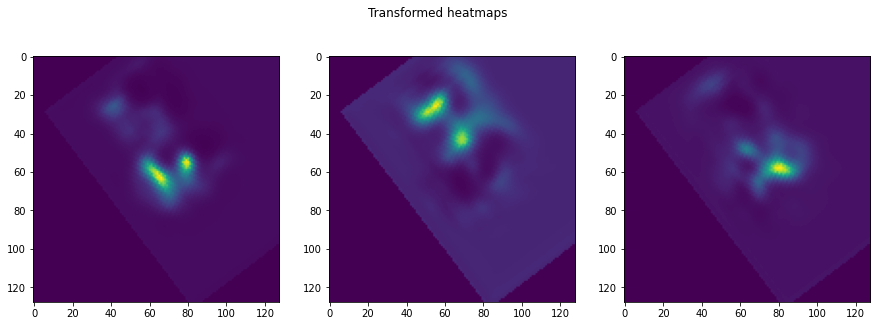

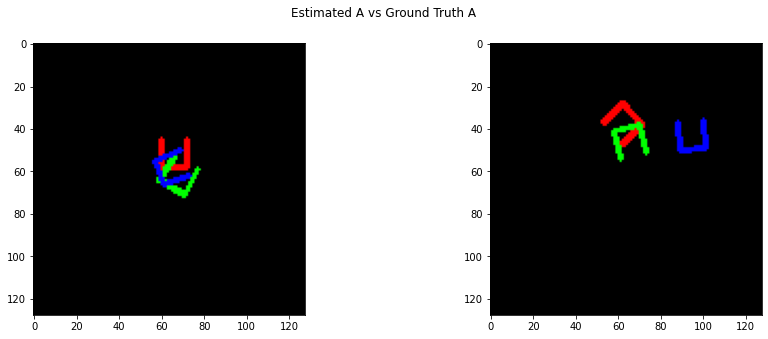

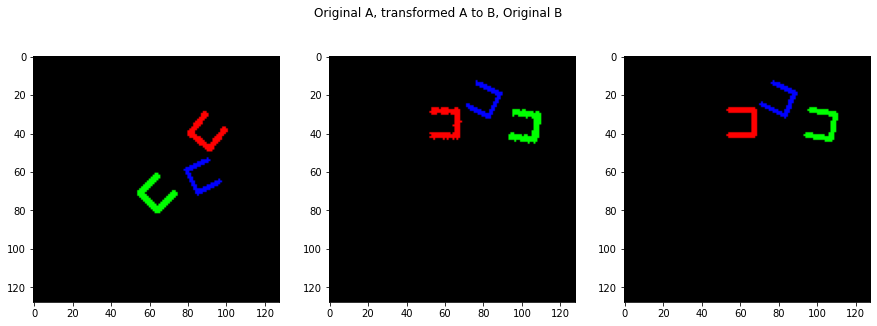

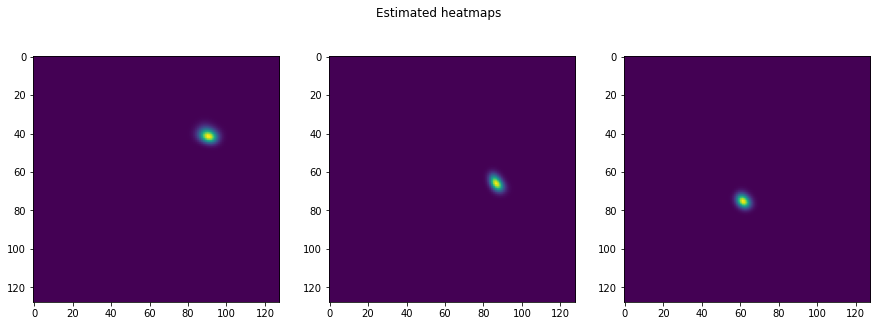

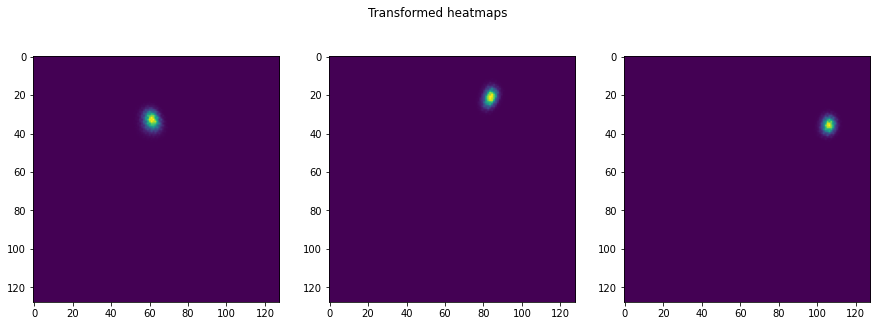

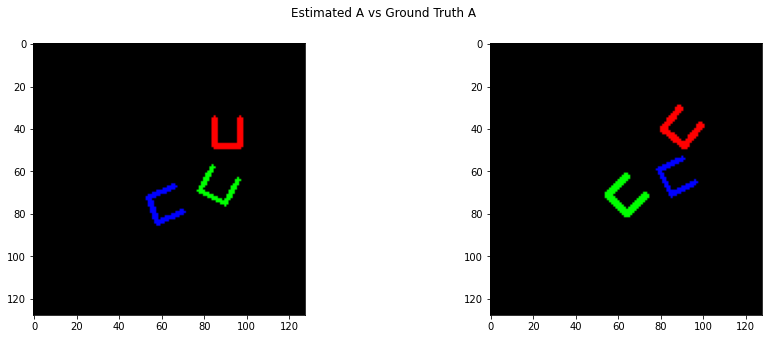

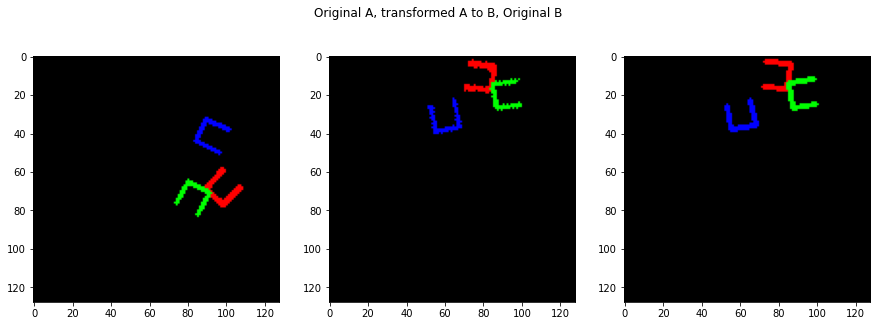

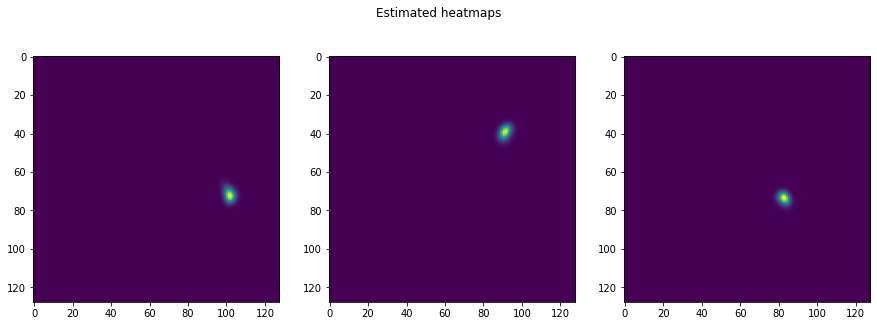

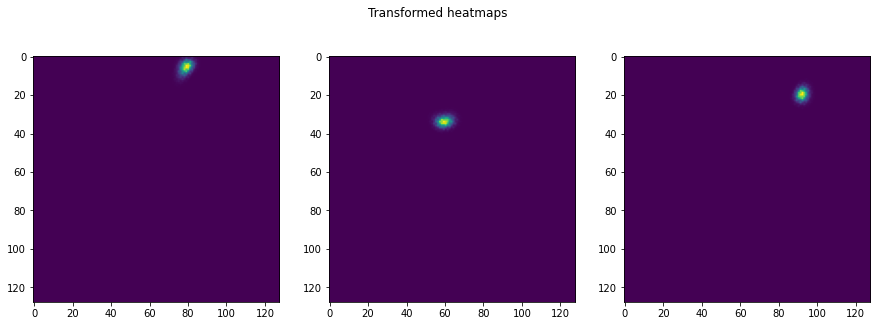

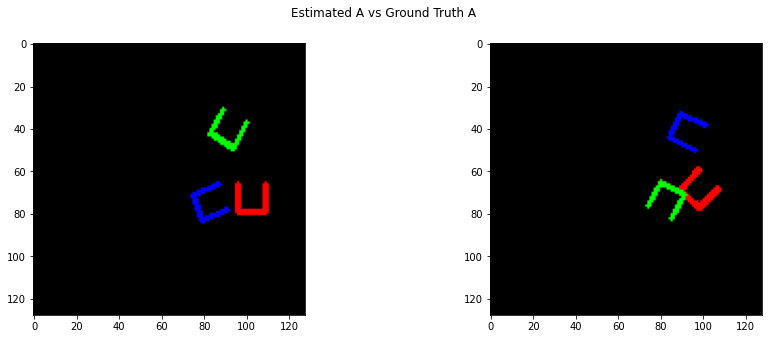

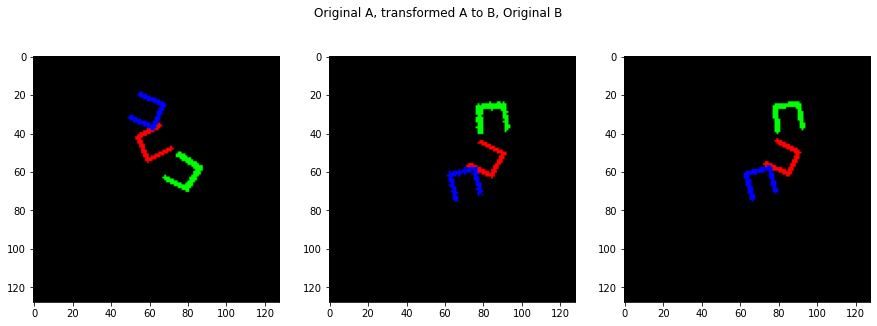

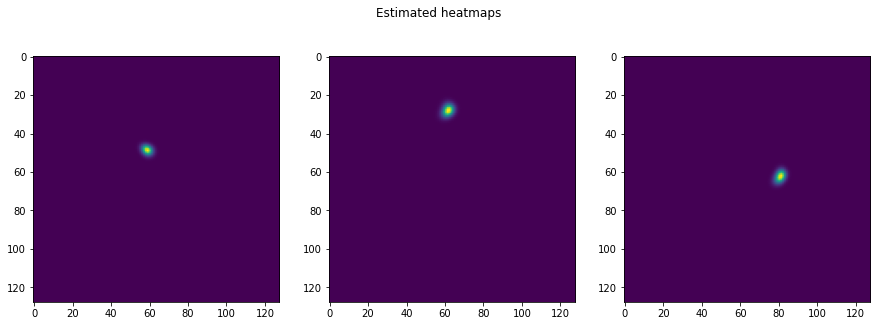

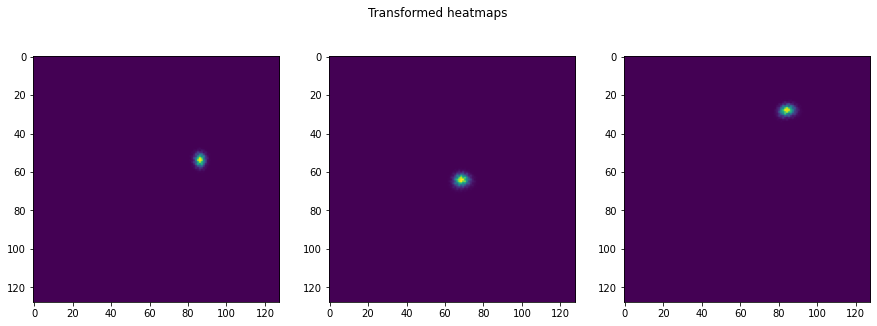

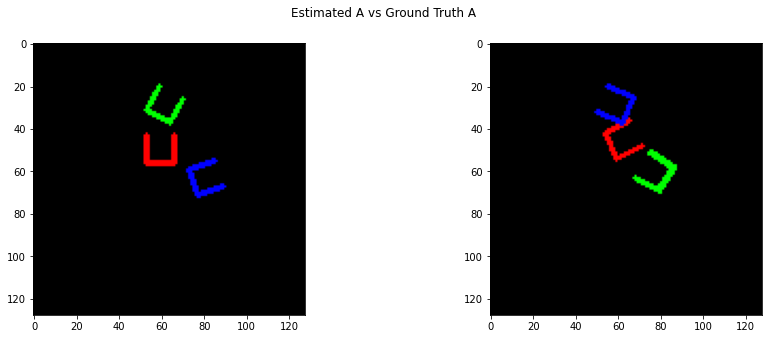

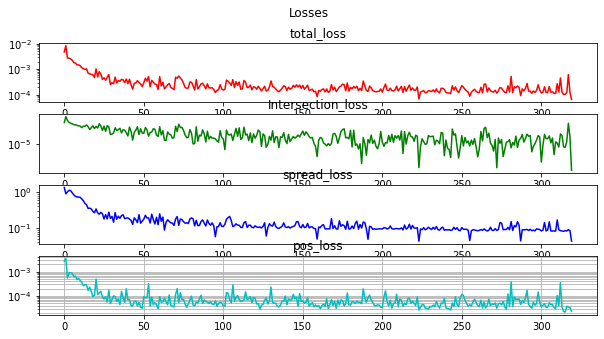

In [85]:
res = 128
n_epochs = 10
epoch_size = 1000
device = torch.device('cuda')

def mat_batch(R, t):

    B = R.shape[0]
    m = torch.empty((B,3,3),device=device)
    m[:, :2, :2] = R
    m[:, :2, 2] = t
    m[:,2] = torch.tensor((0, 0, 1), device=device)

    return m

def transform_hmap(a_R_b, a_t_b, heatmaps_a):

    tensor = torch.zeros(heatmaps_a.shape, device=device)

    for i in range(len(a_t_b)):
        for obj in range(3):
            tmp = np.zeros((128*3,128*3))
            tmp[128-int(a_t_b[0].detach().cpu().numpy()[1]*128):128-int(a_t_b[0].detach().cpu().numpy()[1]*128)+128,128-int(a_t_b[0].detach().cpu().numpy()[0]*128):128-int(a_t_b[0].detach().cpu().numpy()[0]*128)+128] = heatmaps_a[i,obj,0].detach().cpu().numpy()
            #,[-a_t_b[0].detach().cpu().numpy()[1]*128,-a_t_b[0].detach().cpu().numpy()[0]*128])
            img_r = ndimage.rotate(tmp, np.rad2deg(theta_from_R(a_R_b[i].detach().cpu().numpy())), reshape=False,order=0)#ndimage.affine_transform(imgs_a[0].detach().cpu().numpy()[0],r_,[0,0],order=3)

            tensor[i,obj,0,...] = torch.tensor(img_r[128:128*2, 128:128*2])
    return tensor

hmap_pad = nn.ZeroPad2d(128)
center_crop = torchvision.transforms.CenterCrop((res,res))
def trans_hmap_torch(a_R_b, a_t_b, heatmaps_a):

    original_tensor = heatmaps_a.view(heatmaps_a.shape[0],heatmaps_a.shape[1],heatmaps_a.shape[-2],heatmaps_a.shape[-1])
    original_tensor = hmap_pad(original_tensor)
    size_wpad = original_tensor.shape[-2]
    t = torch.zeros(a_t_b.shape, device=device)

    t[...,0:2] = torch.tensor([int(-a_t_b[0,0]*res),int(-a_t_b[0,1]*res)], device=device)
    out = kornia.translate(original_tensor,t, mode="nearest")

    t[...,0:2] = torch.tensor([size_wpad/2,size_wpad/2], device=device)
    r = torch.tensor([np.rad2deg(theta_from_R(a_R_b[0].detach().cpu().numpy()))]*B, device=device)
    out = kornia.rotate(out, r, t, mode="nearest")

    out_croped = center_crop(out)

    return out_croped.view(heatmaps_a.shape)

dataset = Dataset(res=res, epoch_size=epoch_size, supervised=False)
worker_init_fn = lambda *_: np.random.seed()
dataloader = torch.utils.data.DataLoader(dataset, 32, num_workers=4, worker_init_fn=worker_init_fn)
model_1 = Model(res=res, smooth_cs=False).to(device)
model_2 = Model(res=res, smooth_cs=False).to(device)
opt = torch.optim.Adam(model_1.parameters(), lr=1e-3)

pbar = tqdm(total=n_epochs*len(dataloader))
losses = []
intersection_losses = []
gaus_losses = []
pos_losses = []

it = 0
for epoch in range(n_epochs):
    for datapoint in dataloader:
        imgs_a, imgs_b, a_R_b, a_t_b = [d.to(device) for d in datapoint]
        #coords_a, cs_a, heatmaps_a, cs_raw_a, coords_b, cs_b, heatmaps_b, cs_raw_b = model_1(imgs_a, imgs_b)
        coords_a, cs_a, heatmaps_a, cs_raw_a = model_1(imgs_a)
        coords_b, cs_b, heatmaps_b, cs_raw_b = model_1(imgs_b)

        B = imgs_a.shape[0]
        # Bx3x2


        heatmaps_a_trans = trans_hmap_torch(a_R_b, a_t_b, heatmaps_a)#transform_hmap(a_R_b,a_t_b,heatmaps_a) #

        #heatmaps_a_trans = F.softmax(heatmaps_a.view(B, model_1.n_objs, -1), dim=-1).view(B, model_1.n_objs, 1, model_1.res, model_1.res)
        coords_a_b = heatmaps_a_trans * model_1.coords.view(1, 1, 2, model_1.res, model_1.res)  # B, n_objs, 2, r, r
        coords_a_b = coords_a_b.sum(dim=(-1, -2))  # B, n_objs, 2

        '''
        a_to_b = mat_batch(a_R_b, a_t_b)
        coords_a_b_ = torch.matmul(a_to_b, coords_a)
        coords_a_b_ = torch.transpose(coords_a_b_, dim0=-1, dim1=-2)
        coords_a_b_ = torch.div(coords_a_b_[:,:,0:2],coords_a_b_[:,:,2].view(B,3,1))
        '''

        #T = a_t_b.view(a_t_b.shape[0],1, a_t_b.shape[-1]).repeat(1,3,1)
        #simple_loss = F.mse_loss((coords_b - coords_a), T)

        pos_loss = F.mse_loss(coords_a_b, coords_b)

        if it %100 == 0:

            trans_img = trans_hmap_torch(a_R_b, a_t_b, imgs_a)

            fig, axs = plt.subplots(1,3,figsize=(15, 5))
            plt.suptitle("Original A, transformed A to B, Original B")
            axs[0].imshow(imgs_a[0,...].detach().cpu().numpy().transpose(1,2,0))
            axs[1].imshow(trans_img[0,...].detach().cpu().numpy().transpose(1,2,0))
            axs[2].imshow(imgs_b[0,...].detach().cpu().numpy().transpose(1,2,0))
            plt.show()

            #plt.imshow(np.hstack((heatmaps_a[0,0,0].detach().cpu().numpy(),heatmaps_a[0,1,0].detach().cpu().numpy(), heatmaps_a[0,2,0].detach().cpu().numpy())))
            fig, axs = plt.subplots(1,3,figsize=(15, 5))
            plt.suptitle("Estimated heatmaps")
            axs[0].imshow(heatmaps_a[0,0,0].detach().cpu().numpy())
            axs[1].imshow(heatmaps_a[0,1,0].detach().cpu().numpy())
            axs[2].imshow(heatmaps_a[0,2,0].detach().cpu().numpy())
            plt.show()

            #plt.imshow(np.hstack((heatmaps_a_trans[0,0,0].detach().cpu().numpy(),heatmaps_a_trans[0,1,0].detach().cpu().numpy(), heatmaps_a_trans[0,2,0].detach().cpu().numpy())))
            fig, axs = plt.subplots(1,3,figsize=(15, 5))
            plt.suptitle("Transformed heatmaps")
            axs[0].imshow(heatmaps_a_trans[0,0,0].detach().cpu().numpy())
            axs[1].imshow(heatmaps_a_trans[0,1,0].detach().cpu().numpy())
            axs[2].imshow(heatmaps_a_trans[0,2,0].detach().cpu().numpy())
            plt.show()

            cam_R_objs_est = [R_from_theta(theta) for theta in [0,0.5,1.2]]
            cam_t_objs_est = coords_a[0].detach().cpu().numpy()
            img_est = dataset.draw(list(zip(cam_R_objs_est, cam_t_objs_est)))

            #plt.imshow(np.hstack((img_est, imgs_a[0].detach().cpu().numpy().transpose(1, 2, 0))))
            fig, axs = plt.subplots(1,2,figsize=(15, 5))
            plt.suptitle("Estimated A vs Ground Truth A")
            axs[0].imshow(img_est)
            axs[1].imshow(imgs_a[0].detach().cpu().numpy().transpose(1, 2, 0))
            plt.show()

        it +=1


        gaus = gaussian(heatmaps_a.shape,coords_a)
        gaus = torch.tensor(gaus, device=device)

        area_outside_gaus =  torch.sqrt(torch.sum(heatmaps_a)-torch.sum(heatmaps_a*gaus))

        cs_gt = cam_R_objs[..., (0, 1), (0, 0)]

        intersection = torch.sum(heatmaps_a[:,0,...]*heatmaps_a[:,1,...])+torch.sum(heatmaps_a[:,1,...]*heatmaps_a[:,2,...])+torch.sum(heatmaps_a[:,0,...]*heatmaps_a[:,2,...])
        '''
        orn_loss = F.mse_loss(cs, cs_gt)

        loss = pos_loss + orn_loss
        if model.smooth_cs:
            loss += 1e-3 * (cs_raw ** 2).mean()
        '''

        loss = pos_loss  + intersection/10 + area_outside_gaus/1000
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        intersection_losses.append(intersection.detach().cpu())
        gaus_losses.append(area_outside_gaus.detach().cpu())
        pos_losses.append(pos_loss.detach().cpu())

        pbar.update()


fig, axs = plt.subplots(4,figsize=(10, 5))
plt.yscale('log')
fig.suptitle('Losses')
axs[0].plot(losses, 'r')
axs[0].set_title('total_loss')
axs[0].set_yscale('log')
axs[1].plot(intersection_losses, 'g')
axs[1].set_title('Intersection_loss')
axs[1].set_yscale('log')
axs[2].plot(gaus_losses, 'b')
axs[2].set_title('spread_loss')
axs[2].set_yscale('log')
axs[3].plot(pos_losses, 'c')
axs[3].set_title('pos_loss')
axs[3].set_yscale('log')

plt.grid(which='both')

In [ ]:
i = 0
scale = 10
fig, axs = plt.subplots(3, 3, figsize=(3*scale, 4*scale))
img_a_in, img_b_in, cam_R_objs, cam_t_objs = Dataset(supervised=False)[0]
img_a = torch.tensor([img_a_in], device=device)
img_b = torch.tensor([img_b_in], device=device)
coords_a, cs_a, heatmaps_a, cs_raw_a = model_1.forward(img_a)
coords_b, cs_b, heatmaps_b, cs_raw_b  = model_1.forward(img_b)
print(coords_a, coords_b)
axs[0, 0].imshow(img_a_in.transpose(1,2,0))
axs[0, 0].set_title('input_a')

axs[0, 1].imshow(img_b_in.transpose(1,2,0))
axs[0, 1].set_title('input_b')

for j, ax in enumerate(axs[1]):
    ax.imshow(heatmaps_a[i, j, 0].detach().cpu().numpy())
    ax.set_title(f'heatmap {"rgb"[j]}')

for j, ax in enumerate(axs[2]):
    ax.imshow(heatmaps_b[i, j, 0].detach().cpu().numpy())
    ax.set_title(f'heatmap {"rgb"[j]}')


In [ ]:
i = 0
scale = 2
fig, axs = plt.subplots(4, 3, figsize=(3*scale, 4*scale))
img = imgs[i].detach().cpu().numpy().transpose(1, 2, 0)
cs_imgs = cs_raw[i].detach().cpu().numpy() # n_objs, 2, r, r
c_imgs, s_imgs = cs_imgs[:, 0], cs_imgs[:, 1]
cs_ = cs[i].detach().cpu().numpy()

axs[0, 0].imshow(img)
axs[0, 0].set_title('input')

thetas_est = np.arctan2(cs_[:, 1], cs_[:, 0])
cam_R_objs_est = [R_from_theta(theta) for theta in thetas_est]
cam_t_objs_est = coords[i].detach().cpu().numpy()

img_est = dataset.draw(list(zip(cam_R_objs_est, cam_t_objs_est)))
axs[0, 1].imshow(img_est)
axs[0, 1].set_title('reconstruction')

for j, ax in enumerate(axs[1]):
    ax.imshow(heatmaps[i, j, 0].detach().cpu().numpy())
    ax.set_title(f'heatmap {"rgb"[j]}')

for j, ax in enumerate(axs[2]):
    ax.imshow(c_imgs[j])
    ax.set_title(f'cos {"rgb"[j]}')

for j, ax in enumerate(axs[3]):
    ax.imshow(s_imgs[j])
    ax.set_title(f'sin {"rgb"[j]}')

for ax in axs.reshape(-1):
    ax.axis('off')
plt.tight_layout()
plt.show()

Looks good. More training will increase accuracy.